# Linear Regression Covid-19 Model
**Matt Paterson, hello@hireMattPaterson.com**<br>
**Machine Learning Engineer**<br>
**Cloud Brigade, Santa Cruz, CA**<br>
***Ocotber 20, 2020***

## HelloModel
As the 'hello_world' of machine learning, the linear regression model (also known as Ordinary Least Squares) is a linear model that allows us to look at many different features and predict a single continuous variable. In this case, we are trying to use the linear regression model to predict how many deaths a county will see as a result of covid-19, the number of cases it will experience, and the percapita deaths and cases rate. It should be noted that this iteration of the model is using a snapshot from October 10, 2020.

We will also use the Gradient Boosting Regressor, another regression model that predicts continuous variables, but typically is used as an ensemble model, or to put several weaker predictors through a more accurate algorithm.

## Features
In order to create our predictions, this notebook will demonstrate each of the selected features and how they are related to one another and to our target variables. It will also mention a few of the features that we chose not to use in our predictions. Each feature will hopefully help us to see linearity in our model when plotted on an xy axis. More graphical representations will be uploaded in future updates to this notebook prior to 11/01/2020.

There should be independence between features (ie no feature should be an aggregate of another in the same predictive model, such as 'deaths per day' and 'deaths cumulative'). Also, we'll want to see normality in the features when we look at a histogram. While normality won't be perfect, we'll see that nothing really is in predictive modeling. Finally, we really would like to see homoscedasticity as a result of the model, or a minimum of outliers in the data. This way we are modeling the behavior and not the noise.

## The Noise
It should be noted before we dive too deep in to this that places like New York City and counties in Northern New Jersey are expected to appear as outliers in this model. This can either skew the results, or we can use the prior knowledge about these areas to our advantage in future predictions. 

Alternatively, we can take intutive information about these counties like population density, the reliance on trains and busses for public transportation, and the abundance of 'essential' workers whose jobs require them to work in close quarters with other people; and compare these to the traits of rural counties in Georgia, Louisianna, Florida, and New Mexico where we also see an abundance of deaths due to Covid-19 but do not see many of the aforementioned traits. What else do these areas have in common?

The noise in our model may tell a story or it might try to lead us astray. Let's begin.

In [1]:
# Import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble          import GradientBoostingRegressor
from sklearn.linear_model      import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.model_selection   import train_test_split, cross_val_score
from sklearn.cluster           import KMeans
from sklearn.decomposition     import PCA
from sklearn.preprocessing     import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics           import r2_score, mean_squared_error

## The Data
You can look through this repo and see a number of notebooks used to collect, combine, impute, and comb through the data that we'll use. I won't go in to detail on the data in this section

In [2]:
# Create datapath variables to access your data source
path_to_home = '../'
datapath = path_to_home + 'data/'

In [3]:
# Create a filename variable to easily re-use this block
filename = 'cov_soc_eco.csv'

# call the pandas read_csv() function to create a dataframe
covid_df = pd.read_csv(datapath + filename)

# print the firts five rows of your new dataframe
covid_df.head()

,state_abr,state,county,confirmed_cases,deaths,latitude,longitude,fips,percapita_income,median_household_income,...,SNAP_NPA_Participation_Persons,SNAP_All_Participation_Persons,SNAP_PA_Participation_Households,SNAP_NPA_Participation_Households,SNAP_All_Participation_Households,SNAP_All_Issuance,deaths_per_100k,cases_per_100k,jobs_per_100k,av_household_earnings_per_100k
0,WI,Wisconsin,Adams County,316.0,4.0,43.97,-89.77,55001.0,22196.0,44897.0,...,2604.0,2958.0,204.0,1462.0,1666.0,542926.0,19.782394,1562.809100,22378.832839,1.893358e+06
1,WI,Wisconsin,Ashland County,197.0,2.0,46.71,-90.56,55003.0,21115.0,38550.0,...,2121.0,2350.0,143.0,1019.0,1162.0,407986.0,12.851819,1265.904125,54671.636036,2.202699e+06
2,WI,Wisconsin,Barron County,624.0,6.0,45.42,-91.85,55005.0,23337.0,44054.0,...,4503.0,5078.0,351.0,2304.0,2655.0,868505.0,13.261427,1379.188401,53180.532225,2.631615e+06
3,WI,Wisconsin,Bayfield County,156.0,1.0,46.63,-91.18,55007.0,25377.0,44944.0,...,1106.0,1235.0,94.0,560.0,654.0,232296.0,6.650705,1037.509976,30047.885076,2.434617e+06
4,WI,Wisconsin,Brown County,11936.0,75.0,44.48,-87.99,55009.0,27787.0,53119.0,...,19848.0,22738.0,1503.0,9300.0,10803.0,4177040.0,28.350886,4511.948953,64153.140144,3.465478e+06


In [4]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 39 columns):
state_abr                            3040 non-null object
state                                3040 non-null object
county                               3040 non-null object
confirmed_cases                      3040 non-null float64
deaths                               3040 non-null float64
latitude                             3040 non-null float64
longitude                            3040 non-null float64
fips                                 3040 non-null float64
percapita_income                     3040 non-null float64
median_household_income              3040 non-null float64
median_family_income                 3040 non-null float64
number_of_households                 3040 non-null float64
Population                           3040 non-null float64
pct_white                            3040 non-null float64
pct_black                            3040 non-null float64
pct_asian  

Next we'll create a new column called county-state and later we can convert that to an index column.

In [5]:
covid_df['county_state'] = covid_df['county'] + ", " + covid_df['state']

In [6]:
covid_df.set_index('county_state', inplace=True)

In [7]:
covid_df.head(2)

,state_abr,state,county,confirmed_cases,deaths,latitude,longitude,fips,percapita_income,median_household_income,...,SNAP_NPA_Participation_Persons,SNAP_All_Participation_Persons,SNAP_PA_Participation_Households,SNAP_NPA_Participation_Households,SNAP_All_Participation_Households,SNAP_All_Issuance,deaths_per_100k,cases_per_100k,jobs_per_100k,av_household_earnings_per_100k
county_state,,,,,,,,,,,,,,,,,,,,,
"Adams County, Wisconsin",WI,Wisconsin,Adams County,316.0,4.0,43.97,-89.77,55001.0,22196.0,44897.0,...,2604.0,2958.0,204.0,1462.0,1666.0,542926.0,19.782394,1562.809100,22378.832839,1.893358e+06
"Ashland County, Wisconsin",WI,Wisconsin,Ashland County,197.0,2.0,46.71,-90.56,55003.0,21115.0,38550.0,...,2121.0,2350.0,143.0,1019.0,1162.0,407986.0,12.851819,1265.904125,54671.636036,2.202699e+06


In [8]:
covid_df = pd.get_dummies(columns=['state_abr'], data=covid_df, prefix="", prefix_sep="")
covid_df.head()

,state,county,confirmed_cases,deaths,latitude,longitude,fips,percapita_income,median_household_income,median_family_income,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
county_state,,,,,,,,,,,,,,,,,,,,,
"Adams County, Wisconsin",Wisconsin,Adams County,316.0,4.0,43.97,-89.77,55001.0,22196.0,44897.0,51949.0,...,0,0,0,0,0,0,0,1,0,0
"Ashland County, Wisconsin",Wisconsin,Ashland County,197.0,2.0,46.71,-90.56,55003.0,21115.0,38550.0,47587.0,...,0,0,0,0,0,0,0,1,0,0
"Barron County, Wisconsin",Wisconsin,Barron County,624.0,6.0,45.42,-91.85,55005.0,23337.0,44054.0,54827.0,...,0,0,0,0,0,0,0,1,0,0
"Bayfield County, Wisconsin",Wisconsin,Bayfield County,156.0,1.0,46.63,-91.18,55007.0,25377.0,44944.0,55654.0,...,0,0,0,0,0,0,0,1,0,0
"Brown County, Wisconsin",Wisconsin,Brown County,11936.0,75.0,44.48,-87.99,55009.0,27787.0,53119.0,67159.0,...,0,0,0,0,0,0,0,1,0,0


We can now use the index column to make sure that there are no duplicated rows by calling the value_counts function on the index. If any of the top three values are not a '1', then we know we have a duplicate. As you see below, there are no duplicates.

In [9]:
covid_df.index.value_counts(ascending=False).head(3)

Dunklin County, Missouri     1
Bossier Parish, Louisiana    1
Gibson County, Indiana       1
Name: county_state, dtype: int64

## Quick and Dirty - Linear Regression Model
In a minute, we'll do some feature engineering and really build out this model with socio-economic and population data features, but for right now, we can pop the features that we have in to a fast linear regression model to get a sort of baseline look at the pure data.

In [10]:
# Instantiate a model instance
lr = LinearRegression()

In [11]:
# Create a features list containing only the numerical features

cols = dict(covid_df.dtypes)
features = []
for col in cols:
    if "object" in str(cols[col]):
        print(col + "-->" + str(cols[col]))
    else:
        features.append(col)
        print('adding ' + col)
    



state-->object
county-->object
adding confirmed_cases
adding deaths
adding latitude
adding longitude
adding fips
adding percapita_income
adding median_household_income
adding median_family_income
adding number_of_households
adding Population
adding pct_white
adding pct_black
adding pct_asian
adding pct_hispanic
adding pct_native_american
adding pct_hawaiian
State_Abbr-->object
County_Name-->object
adding QMB_Only
adding QMB_plus_Full
adding SLMB_only
adding SLMB_plus_Full
adding QI
adding Other_full
adding Public_Total
adding SNAP_PA_Participation_Persons
adding SNAP_NPA_Participation_Persons
adding SNAP_All_Participation_Persons
adding SNAP_PA_Participation_Households
adding SNAP_NPA_Participation_Households
adding SNAP_All_Participation_Households
adding SNAP_All_Issuance
adding deaths_per_100k
adding cases_per_100k
adding jobs_per_100k
adding av_household_earnings_per_100k
adding AK
adding AL
adding AR
adding AZ
adding CA
adding CO
adding CT
adding DC
adding DE
adding FL
adding GA
a

In [12]:
len(features)

85

In [13]:
# export this dataset for use in the KMeans model:

covid_df[features].to_csv(datapath + '85_cols.csv')

We created 85 features, though we really shouldn't use more than 50-54 features on a Linear Regression Model given that we are only working with 3000 rows of data.

In [14]:
# Create our X matrix and use the deaths column as our y label
X = covid_df[features].drop(columns='deaths')
y = covid_df['deaths']

In [15]:
# Split our data into a testing set and a training set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=.2,
                                                   random_state=42)

In [16]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
lr.score(X_train, y_train)

0.9312581669865041

In [18]:
lr.score(X_test, y_test)

0.9000642298562622

Our model has an R2 score of 90.01%, which is pretty good and only slightly overfit. 

## Quick and Dirty - Gradient Boosting Regressor

In [19]:
gb = GradientBoostingRegressor()

In [20]:
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
print('Training: ', gb.score(X_train, y_train))
print('Testing : ', gb.score(X_test, y_test))

Training:  0.9986799801006553
Testing :  0.9031076545715245


## An overfit data model
When splitting the feature set, we should have split off the confirmed cases data too, as well as the deaths per 100k and the cases per 100k; not just the target data of deaths, as these are direct linear indicators that are not influences on the target column. Also we'll want to predict these each later.

In [22]:
features.remove('deaths')
features.remove('confirmed_cases')
features.remove('deaths_per_100k')
features.remove('cases_per_100k')

targets_list = ['deaths', 'confirmed_cases', 'deaths_per_100k', 'cases_per_100k']

In [23]:
def show_rmse(model_1, model_2):
    '''
    returns 1 for error, 0 for complete
            prints the Root Mean Squared error of one or two models
    '''
    try:    
        print('Root Mean Squared Error of the LR: ',(mean_squared_error(y_test, model_1.predict(X_test)))**(1/2))
        print('Root Mean Squared Error of the GB: ',(mean_squared_error(y_test, model_2.predict(X_test)))**(1/2))
        return 0
    except:
        print('An exception occurred')
        return 1

In [24]:
def i_regress(dataframe, features, target, test_size=0.2, n_estimators=100):
    '''
    returns two models, a LinearRegression() and GradientBoostingRegressor(),
            in that order, and also prints out the r2 scores of each
    dataframe  is the dataframe being used for the testing
    features   is a list of numeric data
    target     is a string, the column name from the dataframe of the target
    test_size  is a float between 0.0 and 1.0 exclusive used
               in the train_test_split() function
    n_estimators is an int used in the GradientBoostingRegressor()
    '''
    
    # import librarires if exporting this function to a useful library
    
    lr = LinearRegression()
    gb = GradientBoostingRegressor(n_estimators=n_estimators)
    
    X = dataframe[features]
    y = dataframe[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                       random_state=42)
    lr.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    
    print(f'Models successfully built: Target = "{target}"')
    print('*'*30)
    print('Training Scores: ')
    print('LinearRegression         : ', lr.score(X_train, y_train))
    print('GradientBoostingRegressor: ', gb.score(X_train, y_train))    
    print('*'*30)
    print('Testing Scores: ')
    print('LinearRegression         : ', lr.score(X_test, y_test))
    print('GradientBoostingRegressor: ', gb.score(X_test, y_test))
    
    print('*'*30)
    show_rmse(lr, gb)
    
    return lr, gb

In [25]:
lr_2, gb_2 = i_regress(covid_df, features, target='deaths', test_size=0.3, n_estimators=500)

Models successfully built: Target = "deaths"
******************************
Training Scores: 
LinearRegression         :  0.9037050545292863
GradientBoostingRegressor:  0.9994077384723852
******************************
Testing Scores: 
LinearRegression         :  0.8770981806289302
GradientBoostingRegressor:  0.9220538995750452
******************************
An exception occurred


In [26]:
lr_3 = LinearRegression()
gb_3 = GradientBoostingRegressor(n_estimators=500)

X = covid_df[features]
y = covid_df['deaths']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                   random_state=42)

lr_3.fit(X_train, y_train)
gb_3.fit(X_train, y_train)

print('Models successfully built:')
print('*'*30)
print('Training Scores: ')
print('LinearRegression         : ', lr_3.score(X_train, y_train))
print('GradientBoostingRegressor: ', gb_3.score(X_train, y_train))    
print('*'*30)
print('Testing Scores: ')
print('LinearRegression         : ', lr_3.score(X_test, y_test))
print('GradientBoostingRegressor: ', gb_3.score(X_test, y_test))

Models successfully built:
******************************
Training Scores: 
LinearRegression         :  0.9037050545292863
GradientBoostingRegressor:  0.9994077384723852
******************************
Testing Scores: 
LinearRegression         :  0.8770981806289302
GradientBoostingRegressor:  0.9216472488016257


In [27]:
(mean_squared_error(y_test, lr_3.predict(X_test)))**(1/2)

128.6206087725723

## Too good to be true?
Above, we see r2 scores over 90%. However, we are only able to predict the deaths per county with a root mean squared error of 107-129, which is nowhere near perfect. The majority of counties have seen fewer than 100 deaths.

Here's a historgram of the number of deaths per county:

In [28]:
def graph_words(word_color):
    '''
    establishes the word color for a graph to more easily transfer to ppt slides
    '''
    #import matplotlib.pyplot as plt
    return plt.rcParams.update({'text.color' : word_color,
                     'axes.labelcolor' : word_color, 'xtick.color' : word_color,
                    'ytick.color' : word_color})

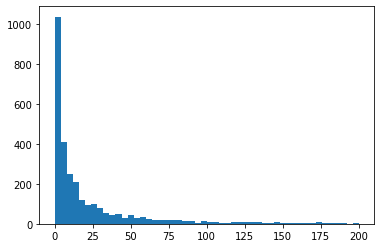

In [29]:
plt.hist(covid_df['deaths'], bins=50, range=(0, 200));

What do the models look like when we predict the number of confirmed cases?

In [30]:
lr_4, gb_4 = i_regress(covid_df, features, target='confirmed_cases', test_size=.3, n_estimators=500)

Models successfully built: Target = "confirmed_cases"
******************************
Training Scores: 
LinearRegression         :  0.9548984148760504
GradientBoostingRegressor:  0.9994257137247211
******************************
Testing Scores: 
LinearRegression         :  0.9588081953100046
GradientBoostingRegressor:  0.7167156105608934
******************************
Root Mean Squared Error of the LR:  10199.387086233695
Root Mean Squared Error of the GB:  7463.312574589547


The Gradient Boosting Regressor is pretty overfit, but the linear regression model seems to be right on. Of course, I am skeptical whenever I see a high score, even in an r2 score.

Further, the RMSE for the LR model is over 10K, meaning it could be off by 10K deaths per county. Even with an RMSE of close to 8K for the Gradient Boosting model, we can see in the following histogram that this is not the most trustworthy prediction:

Text(0.5, 1.0, 'Histogram of Cases per County (up to 20K)')

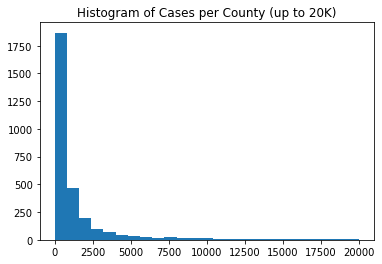

In [31]:
graph_words('black')
plt.hist(covid_df['confirmed_cases'], bins=25, range=(0, 20_000));
plt.title('Histogram of Cases per County (up to 20K)')

We'll try to tweak this model before moving to the next target

In [32]:
lr_5, gb_5 = i_regress(covid_df, features, target='confirmed_cases', test_size=.5, n_estimators=500)

Models successfully built: Target = "confirmed_cases"
******************************
Training Scores: 
LinearRegression         :  0.9597100967857539
GradientBoostingRegressor:  0.999695111611242
******************************
Testing Scores: 
LinearRegression         :  0.6979116052489728
GradientBoostingRegressor:  0.8312489350398764
******************************
Root Mean Squared Error of the LR:  9620.197281135841
Root Mean Squared Error of the GB:  8322.362097584723


Growing the test size, that is, training the model on less data and allowing it to try and make predictions on more data, seems to help our overfitting problem a little on the Gradient Boosting Model but actually worsens it considerably in the Linear Regression Model. Still, the RMSE is about the same on each, getting slightly better on the LR and slightly worse on the GB.

For this next run we'll lower the number of estimators in the gradient boosting regressor

In [33]:
lr_6, gb_6 = i_regress(covid_df, features, target='confirmed_cases', test_size=.5, n_estimators=50)

Models successfully built: Target = "confirmed_cases"
******************************
Training Scores: 
LinearRegression         :  0.9597100967857539
GradientBoostingRegressor:  0.9905169271058933
******************************
Testing Scores: 
LinearRegression         :  0.6979116052489728
GradientBoostingRegressor:  0.8370152387853718
******************************
Root Mean Squared Error of the LR:  9620.197281135841
Root Mean Squared Error of the GB:  8638.06416999905


That didn't help, it slightly increased the overfitting, actually. This time I'll try to increase the 'test_size' even more, and then I'll move on to feature engineering and tailoring the features a bit.

In [34]:
lr_7, gb_7 = i_regress(covid_df, features, target='confirmed_cases', test_size=.6, n_estimators=50)

Models successfully built: Target = "confirmed_cases"
******************************
Training Scores: 
LinearRegression         :  0.9651679110441103
GradientBoostingRegressor:  0.9912984947472615
******************************
Testing Scores: 
LinearRegression         :  0.7216786966435891
GradientBoostingRegressor:  0.7570555204652214
******************************
Root Mean Squared Error of the LR:  10266.929907095175
Root Mean Squared Error of the GB:  7675.26065259916


## Percapita predictions


In [35]:
lr_8, gb_8 = i_regress(covid_df, features, target='deaths_per_100k')
    

Models successfully built: Target = "deaths_per_100k"
******************************
Training Scores: 
LinearRegression         :  0.48856500389276997
GradientBoostingRegressor:  0.6826756704587726
******************************
Testing Scores: 
LinearRegression         :  0.38867521633326696
GradientBoostingRegressor:  0.4134100830532744
******************************
Root Mean Squared Error of the LR:  363.01088306265484
Root Mean Squared Error of the GB:  359.1653943599922


In [36]:
lr_9, gb_9 = i_regress(covid_df, features, target='cases_per_100k')

Models successfully built: Target = "cases_per_100k"
******************************
Training Scores: 
LinearRegression         :  0.5438158522477373
GradientBoostingRegressor:  0.758344982228098
******************************
Testing Scores: 
LinearRegression         :  0.48454067165469894
GradientBoostingRegressor:  0.506965351009109
******************************
Root Mean Squared Error of the LR:  2378.62509275863
Root Mean Squared Error of the GB:  2384.1041936740085


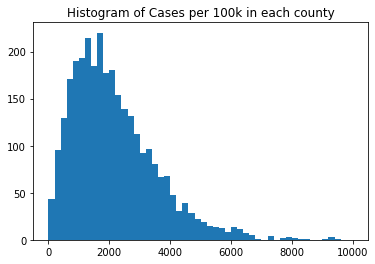

In [37]:
graph_words('black')
plt.hist(covid_df['cases_per_100k'], bins=50, range=(0, 10_000));
plt.title('Histogram of Cases per 100k in each county');

As we can see, the predictions get even worse when we try to run them for predicting the deaths or cases percapita in a county. This is likely because most of our features are raw numbers and not converted to percentages per capita, thus the model is understanding each as a quantity and wants to predict a total as opposed to a percapita formula.

## MORE DATA!! Feature Engineering

Now that we have created our starting point, let's identify the features that have the strongest correlations to the target columns, and engineer columns that show the percapita effects of each input. In other words, what things are most likely to indicate a higher number of deaths or confirmed cases of covid, and also what does each feature look like from a percapita standpoint?

In [38]:
# Receate a features list containing only the numerical features

cols = dict(covid_df.dtypes)
features = []
for col in cols:
    if "object" not in str(cols[col]) and col not in targets_list:
        features.append(col)
len(features)

81

In [39]:
# Create a list of the state columns and seperate them from the features list
states = []
for feat in features:
    if len(feat)==2 and 'Q' not in feat:
        states.append(feat)
for state in states:
    features.remove(state)
len(states)

51

In [40]:
len(features)

30

In [41]:
# create a locations list
locations = ['latitude', 'longitude', 'fips']

for loc in locations:
    features.remove(loc)
len(features)

27

In [42]:
features

['percapita_income',
 'median_household_income',
 'median_family_income',
 'number_of_households',
 'Population',
 'pct_white',
 'pct_black',
 'pct_asian',
 'pct_hispanic',
 'pct_native_american',
 'pct_hawaiian',
 'QMB_Only',
 'QMB_plus_Full',
 'SLMB_only',
 'SLMB_plus_Full',
 'QI',
 'Other_full',
 'Public_Total',
 'SNAP_PA_Participation_Persons',
 'SNAP_NPA_Participation_Persons',
 'SNAP_All_Participation_Persons',
 'SNAP_PA_Participation_Households',
 'SNAP_NPA_Participation_Households',
 'SNAP_All_Participation_Households',
 'SNAP_All_Issuance',
 'jobs_per_100k',
 'av_household_earnings_per_100k']

Look at the correlations of the features now within each list

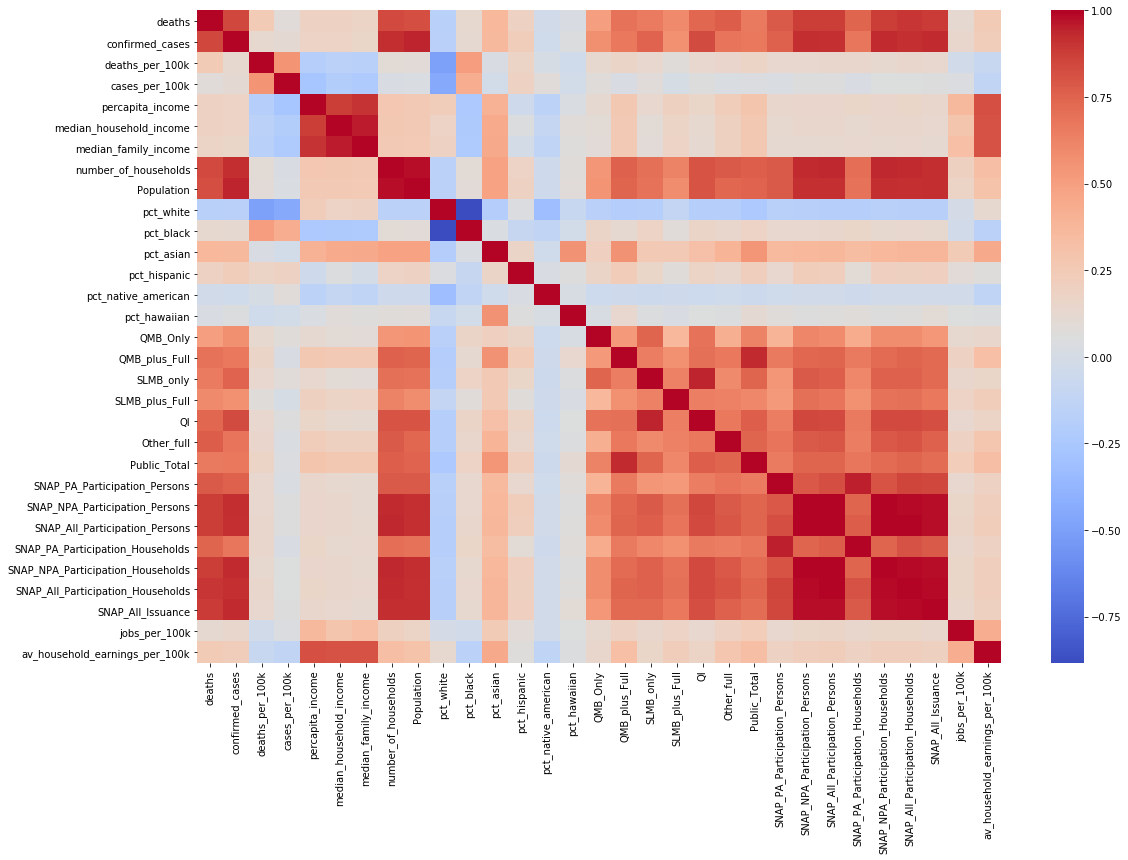

In [43]:
plt.figure(figsize=(18, 12))
sns.heatmap(covid_df[targets_list+features].corr(), cmap='coolwarm');

We see that the strongest correlations to our percapita data at the moment are the pct_white, pct_black, percapita_income, median_household_income, median_family_income 

In [44]:
strongest = ['deaths_per_100k', 'cases_per_100k', 'pct_white',
             'pct_black', 'percapita_income', 'median_household_income', 'median_family_income']

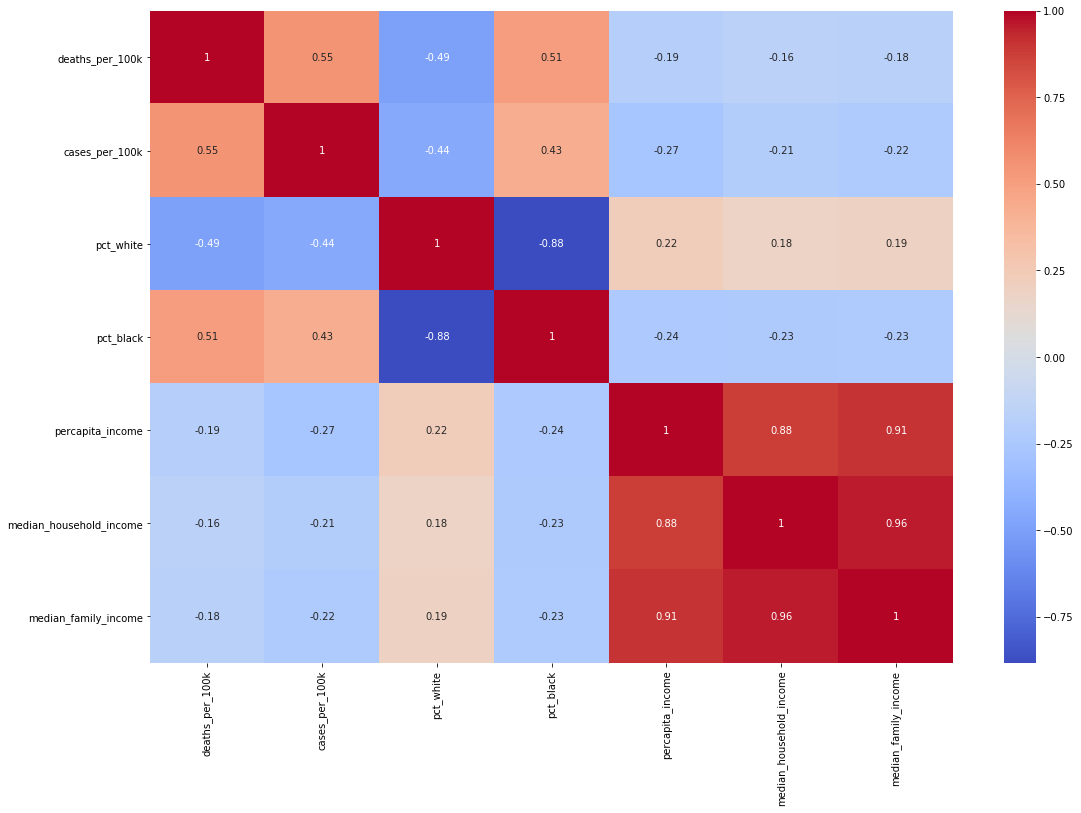

In [55]:
plt.figure(figsize=(18, 12))

#sns.set(font_scale=3) # font size 2
graph_words('black')
sns.heatmap(covid_df[strongest].corr(), cmap='coolwarm', annot=True );

## Racial Component

Clearly, the largest positive correlation to percapita deaths in a county is the percentage of African Americans living in that county. Conversely, the strongest negative correlation to the percapita deaths is the percentage of white people living in that county. So as the percentage of black people increases, the number of people percaptia dying of covid increases, and as the percentage of white people increases, the number of people percapita dying of covid decreases. 

## Economic Component
Also negatively correlated to deaths per capita in a county is the percapita income, median household income, and median family income. In other words, as the amount of money an average family is earning decreases, the number of people percapita that are dying of covid increases.

Percapita income decreases in one of three ways:
1. there are more children per working adult, and thus a general mean reduction
    - This is off-set by the median household income measurement, which also has the same negative correlation
2. the average salary or earnings potential is lower in that county than in other counties
3. the unemployment rate is higher in that county than in other counties

The last point is espeically precient given the current state of employment and/or the ability for families to provide food, shelter, and basic healthcare in the wake of our pandemic response and a lack of relief money coming back to the states, cities, counties, and households from the federal government.

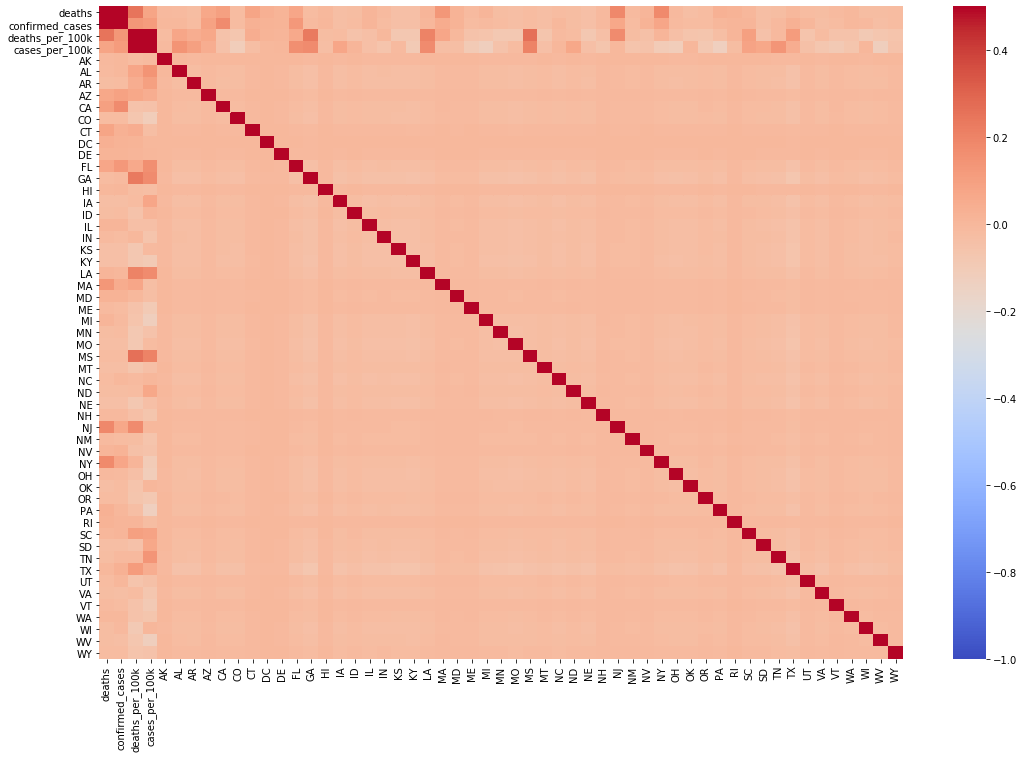

In [46]:
plt.figure(figsize=(18, 12))
sns.heatmap(covid_df[targets_list+states].corr(), vmin=-1.0, vmax=0.5, cmap='coolwarm');

## State to State Analysis

## We see that very few states show a stronger correlation than others to percapita deaths

Looking at the heatmap above, we can see that the states with the highest percapita cases are Alabama, Arkansas, Arizona, Florida, Georgia, Iowa, Louisiana, Mississippi, North Dakota, South Carolina, South Dakota, Tennessee, and Texas. We'll look later at the time-series data to see if this is due to more recent spikes or a steady build-up over time.

In that same heatmap we clearly see that the deadliest states percapita include Georgia, Louisiana, Mississippi, and New Jersey, with Texas, South Carolina, Massachussets, Florida, and Arizona closely behind them.


### NOTE : IF time permits, create all of the percapita columns with the rest of the data and see how those compare on the heatmap. If nothing else it should help to solidify the socio-economic binary that we are looking at

This is done in the Kmeans notebook but should be added here as well to see how it affects the regression models